<a href="https://colab.research.google.com/github/sansv8/ai_org_image_classification/blob/main/Last_Copy_of_PantsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload files
!git clone 'https://github.com/cbennudr/ai_org_image_classification.git'

Cloning into 'ai_org_image_classification'...
remote: Enumerating objects: 1000, done.
remote: Counting objects: 100% (499/499), done.
remote: Compressing objects: 100% (472/472), done.
remote: Total 1000 (delta 49), reused 468 (delta 26), pack-reused 501
Receiving objects: 100% (1000/1000), 24.89 MiB | 32.84 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# Imports and function definitions
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from PIL import Image, ImageOps
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pathlib
import glob

def resize(image, dimensions):
    old_width, old_height = image.size

    # Original is too tall
    if old_width / old_height < dimensions[0] / dimensions[1]:
        # Crop image
        new_height = old_width * dimensions[1] / dimensions[0]
        image = image.crop((0, (old_height - new_height) / 2,
                            old_width, (old_height + new_height) / 2))

        # Resize image
        return image.resize(dimensions)

    else:  # Original is too wide
        # Crop image
        new_width = old_height * dimensions[0] / dimensions[1]
        image = image.crop(((old_width - new_width) / 2, 0,
                            (old_width + new_width) / 2, old_height))

        # Resize image
        return image.resize(dimensions)

In [3]:
# Invariants (Don't change on your own)
images_loc = "ai_org_image_classification/pants_classification/pants_images"
labels_name = "ai_org_image_classification/pants_classification/labels.csv"
label_column = "Pants/Shorts"
k_folds = 2

In [4]:
# THINGS TO CHANGE

# Parameters (Change to improve model)
epochs = 15
pixel_range = (0, 1)
image_dim = (400, 400)  # (width, height)
stretch_images = True  # Stretch or crop images to fit aspect ratio
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bi_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True);
bi_accurary = keras.metrics.BinaryAccuracy(threshold=0.0)
optimizer = "adam"
oversample = True  # Duplicate images from smaller categories

# Model (Change to improve model)
# Different layers can be researched at https://www.tensorflow.org/api_docs/python/tf/keras/layers
# Default model contains four layers, excluding the inputs:
# Flatten - Convert image array to a 1-D vector
#   input_shape determines the inputs of the network
# Dense with 128 nodes - Standard neural network layer
# Dropout - While training, turns off inputs of previous layer
#   20% of the time to prevent overfitting
# Dense with 2 nodes - Output layer with no activation function applied

model = keras.models.Sequential()
model.add(keras.layers.Conv1D(64, (3), input_shape=(image_dim), activation='relu'))
model.add(keras.layers.Dropout(.25))
model.add(keras.layers.Conv1D(32, (3), activation='relu'))
model.add(keras.layers.Dropout(.25))
model.add(keras.layers.Conv1D(16, (3), activation='relu'))
model.add(keras.layers.MaxPooling1D())
model.add(keras.layers.Dropout(.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(.25))
model.add(keras.layers.Dense(2, activation='softmax')) 
  # Final layer outputs = number of labels



In [5]:
# RUN AFTER CHANGING PARAMETERS
# No need to rerun if only changing model

# Import labels
labels = pd.read_csv(labels_name)

# Import images
images = []

for name in labels["Data Number"]:
    images.append(Image.open(images_loc + "/" + str(name) + ".jpg"))

    # Resize image
    if stretch_images:
        images[-1] = images[-1].resize(image_dim)

    else:
        images[-1] = resize(images[-1], image_dim)

# Specify particular label category
labels = labels[label_column]

# Convert labels to numbers for training
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)

if oversample:
    # Calculate largest class size
    # len([0 for label in labels if label == i]) returns amount of data in class i
    max_class_size = max([len([0 for label in labels if label == i]) for i in range(len(encoder.classes_))])
    
    # Add random elements of smaller classes until they are of the same size
    data_to_add = []
    
    for i in range(len(encoder.classes_)):
        number_to_add = max_class_size - len([0 for label in labels if label == i])
        possible_choices = [(images[j], labels[j]) for j in range(len(labels)) if labels[j] == i]

        for _ in range(number_to_add):
            data_to_add.append(random.choice(possible_choices))

    images += [data[0] for data in data_to_add]
    labels = np.append(labels, [data[1] for data in data_to_add])

# Convert to grayscale
gray_images = []

for i in range(len(images)):
    # Convert grayscale and numpy array
    gray_images.append(np.array(ImageOps.grayscale(images[i])))
    images[i] = np.array(images[i])

# Scale pixel brightnesses
for i in range(len(images)):
    images[i] = images[i] * (pixel_range[1] - pixel_range[0]) / 255.0
    images[i] += pixel_range[0]
    gray_images[i] = gray_images[i] * (pixel_range[1] - pixel_range[0]) / 255.0
    gray_images[i] += pixel_range[0]


In [6]:
# Create a graph to check the loss of the function
def plot_loss(history):
  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.ylim(0, 1)
  plt.title('Epoch vs Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

history = {
    "loss" : [],
    "val_loss" : [],
}

Fold 1:
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 3s 197ms/step - loss: 0.1901 - accuracy: 0.9374 - val_loss: 0.1584 - val_accuracy: 0.9464
Epoch 2/15
14/14 [==============================] - 3s 184ms/step - loss: 0.1760 - accuracy: 0.9418 - val_loss: 0.2060 - val_accuracy: 0.9107
Epoch 3/15
14/14 [==============================] - 3s 180ms/step - loss: 0.1530 - accuracy: 0.9396 - val_loss: 0.1649 - val_accuracy: 0.9375
Epoch 4/15
14/14 [==============================] - 3s 181ms/step - loss: 0.1192 - accuracy: 0.9508 - val_loss: 0.1737 - val_accuracy: 0.9286
Epoch 5/15
14/14 [==============================] - 3s 182ms/step - loss: 0.0765 - accuracy: 0.9776 - val_loss: 0.1577 - val_accuracy: 0.9286
Epoch 6/15
14/14 [==============================] - 3s 181ms/step - loss: 0.0690 - accuracy: 0.9732 - val_loss: 0.2189 - val_accuracy: 0.9286
Epoch 7/15
14/14 [==============================] - 3s 181ms/step - loss: 0.0823 - accuracy: 0.9709 - val_loss: 0.1428 - val_accuracy: 0.9464
Epoch 8/15
14/14 

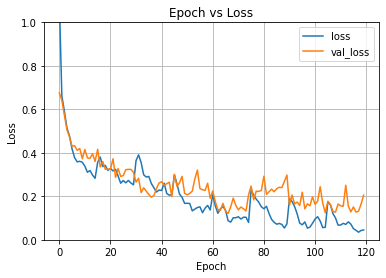

In [10]:
# RUN AFTER CHANGING PARAMETERS OR MODEL

# Create training and test sets
# Data is divided into k_folds groups
# For 0 <= i < k_folds, group i is the test set, while everything else is the training set
# Each element of fold_indices is of the form (train_indices, test_indices)
# Training image set number i is then np.array([gray_images[index] for index in fold_indices[i][0]])
# Training label set number i is then np.array([labels[index] for index in fold_indices[i][0]])
# Test image set number i is then np.array([gray_images[index] for index in fold_indices[i][1]])
# Test label set number i is then np.array([labels[index] for index in fold_indices[i][1]])
fold_splitter = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_indices = []

for i in fold_splitter.split(gray_images, labels):
    fold_indices.append(i)

for i in range(len(fold_indices)):
    np.random.shuffle(fold_indices[i][0])
    np.random.shuffle(fold_indices[i][1])
    
# Define the training regimine the model will go through
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# Train the model
responses = []
answer_key = []

for i in range(k_folds):
    print("Fold {}:".format(i + 1))
    X_train = np.array([gray_images[index] for index in fold_indices[i][0]])
    y_train = np.array([labels[index] for index in fold_indices[i][0]])
    X_test = np.array([gray_images[index] for index in fold_indices[i][1]])
    y_test = np.array([labels[index] for index in fold_indices[i][1]])

    his = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)
    print("\n", end="")

    history["loss"].extend(his.history["loss"])
    history["val_loss"].extend(his.history["val_loss"])
    responses = np.append(responses, model.predict(X_test).argmax(axis=1))
    answer_key = np.append(answer_key, y_test)

# Evaluate the model
print("Accuracy: {}".format(accuracy_score(answer_key, responses)))

# Calculate confusion matrix
class_names = encoder.classes_
conf_mat = pd.DataFrame(np.transpose(confusion_matrix(
    answer_key, responses, labels=encoder.transform(class_names))), index=class_names, columns=class_names)
print("Confusion Matrix (Predicted x Actual):")
print(conf_mat, "\n")

plot_loss(history)


In [11]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [12]:
image = "ai_org_image_classification/Color-Identification/TestPants.jpg"
image = Image.open(image)
pants = []
image = image.resize(image_dim)
image = np.array(ImageOps.grayscale(image))
image = image * (pixel_range[1] - pixel_range[0]) / 255.0
image += pixel_range[0]
pants.append(image)
pants = np.array(pants)
pants.shape




(1, 400, 400)

In [13]:
new_model = keras.models.load_model('saved_model/my_model')
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 398, 64)           76864     
                                                                 
 dropout (Dropout)           (None, 398, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 396, 32)           6176      
                                                                 
 dropout_1 (Dropout)         (None, 396, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 394, 16)           1552      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 197, 16)          0         
 )                                                               
                                                        

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
new_model.predict(pants)

array([[1.0000000e+00, 2.1163298e-15]], dtype=float32)